In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import os
import sys
import re
project_root = os.path.dirname(os.path.dirname(os.path.abspath('Pheno.ipynb')))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)
plt.style.use('default')
%load_ext autoreload 
%autoreload 2

In [2]:
n_input = 1000
n_hidden = 128
n_latent = 32
n_labels = 2
batch_size = 32
n_epoch = 100

In [3]:
from model import BulkVAE
from dataset import TCGADataset, collate_fn
model = torch.load('../model.pth')
train_dataset = TCGADataset('../data/Cleaned_data/Liver/train_exp.csv', '../data/Cleaned_data/Liver/train_label.csv', 'sample_type')
test_dateset = TCGADataset('../data/Cleaned_data/Liver/test_exp.csv', '../data/Cleaned_data/Liver/test_label.csv', 'sample_type')


/tmp/ipykernel_15814/3263714549.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../model.pth')


In [4]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dateset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [5]:
total_latent = []
total_train = []
target_label = []
target_wnt = []
for batch in train_loader:
    data_batch, target_batch, batch_index, mean, variance, idx = batch
    latent = model.get_latents(data_batch)
    total_latent.append(latent)
    target_label.append(target_batch)
    total_train.append(data_batch)
    target_wnt.append(idx)

target_wnt = [item for sublist in target_wnt for item in sublist]
new_label = train_dataset.label.iloc[target_wnt, :]['tumor_stage']
for batch in test_loader:
    data_batch, target_batch, batch_index, mean, variance, idx = batch
    latent = model.get_latents(data_batch)
    total_latent.append(latent)
    target_label.append(target_batch)
    total_train.append(data_batch)
    target_wnt.append(idx)
total_latent = torch.cat(total_latent, dim=0)
total_train = torch.cat(total_train, dim=0)
total_latent = total_latent.detach().numpy()
target_label = torch.cat(target_label, dim=0)
total_latent.shape

(418, 64)

In [6]:
new_label

189    1
193    1
88     4
171    4
19     2
      ..
343    2
284    1
311    0
330    0
26     1
Name: tumor_stage, Length: 334, dtype: int64

0
1


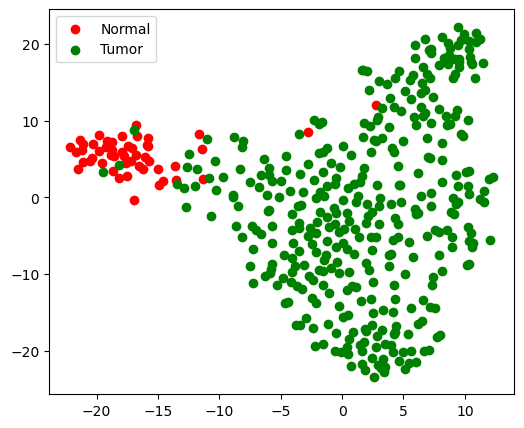

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(total_latent)
# X_2d = PCA(n_components=2).fit_transform(total_latent)
target_ids = range(2)
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(target_ids, colors, ['Normal', 'Tumor']):
    print(i)
    plt.scatter(X_2d[target_label == i, 0], X_2d[target_label == i, 1], c=c, label=label)
    plt.legend()
plt.show()
# plt.figure(figsize=(6, 5))
# for i, c, label in zip(range(5), colors, range(5)):
#     print(i)
#     plt.scatter(X_2d[new_label == i, 0], X_2d[new_label == i, 1], c=c, label=label)
#     plt.legend()
# plt.show()

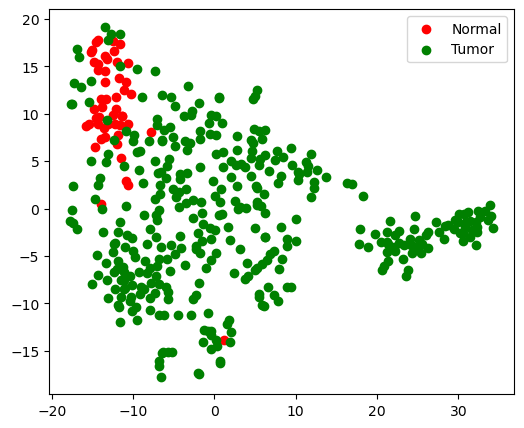

In [11]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(total_train)
# X_2d = PCA(n_components=2).fit_transform(total_train)
target_ids = range(5)
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(target_ids, colors, ['Normal', 'Tumor']):
    plt.scatter(X_2d[target_label == i, 0], X_2d[target_label == i, 1], c=c, label=label)
    plt.legend()
plt.show()